In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
%pip install evaluate
import evaluate
from datasets import Dataset
from math import exp,log

In [ ]:
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data["train"])
df_finetune, df_score = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
dataset = Dataset.from_pandas(df_finetune)
model_name = "vinai/vinai-translate-en2vi-v2"
tokenizer = AutoTokenizer.from_pretrained("vinai/vinai-translate-en2vi-v2", src_lang="vi_VN")


# detect error
# for i in dataset:
#     try :
#         tokenizer.encode(i["source"])
#         tokenizer.encode(i["target"])
#     except:
#         print(i["source"])
#         print(i["target"])


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["source"],
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    labels = tokenizer(
        examples["target"],
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )


    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset.column_names
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

training_args = TrainingArguments(
    output_dir="./monster",
    run_name = 'ml',
    eval_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=50,
    save_total_limit=2,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
)
print('Start train:')
trainer.train()

trainer.save_model("./final")

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

Start train:


Step,Training Loss
50,4.242500
100,0.420400
150,0.150400
200,0.098500
250,0.074600
300,0.062800
350,0.051000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1024, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


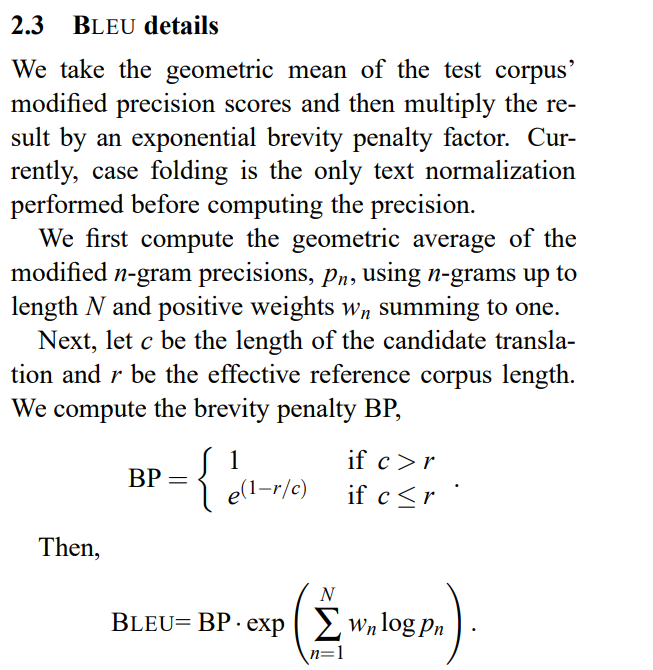

In [ ]:
def BP(s1, s2):
    return 1 if s2 > s1 else exp(1 - s1 / s2)

def custom_bleu(text, target):
    s2 = len(text.split())
    s1 = len(target.split())

    result = bleu.compute(predictions=[text], references=[[target]])
    precisions = result['precisions']  # tuple: (1-gram, 2-gram, 3-gram, 4-gram)

    smoothie = 1e-9
    clipped_precisions = [p + smoothie for p in precisions]

    max_n = min(4, s2)
    weights = [1 / max_n] * max_n  # assume the same w for all n-gram (for all n from 1 to 4 )
    log_precisions = [w * log(clipped_precisions[i]) for i, w in enumerate(weights)]

    return BP(s1, s2) * exp(sum(log_precisions[:max_n]))


In [ ]:
model1 = AutoModelForSeq2SeqLM.from_pretrained("./final")
model1.to(device)

def translate(texts, model, batch_size=16):
    translated_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        input_ids = tokenizer(batch, padding=True, return_tensors="pt").to(device)
        output_ids = model.generate(
            **input_ids,
            decoder_start_token_id=tokenizer.lang_code_to_id["vi_VN"],
            num_return_sequences=1,
            num_beams=5,
            early_stopping=True
        )
        vi = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        translated_texts.extend(vi)
    return translated_texts


bleu = evaluate.load("bleu")


for model_key, model_col, bleu_col in zip([model, model1], ['before', 'after'], ['BLEU[target - before]', 'BLEU[target - after]']):
    df_score[model_col] = translate(df_score['source'].tolist(), model_key)
    # df_score[f'BLEU_detail[target - {model_col}]'] = [bleu.compute(predictions=[i], references=[j]) for i,j in zip(df_score[model_col], df_score['target'])]
    # df_score[bleu_col] = df_score[f'BLEU_detail[target - {model_col}]'].apply(lambda x: x['bleu'])
    df_score[bleu_col] = [custom_bleu(i,j) for i,j in zip(df_score[model_col], df_score['target'])]


df_score.to_csv('result.csv', index=False, encoding='utf-8')

print('Mean_bleu_before:',df_score['BLEU[target - before]'].mean())
print('Mean_bleu_after:', df_score['BLEU[target - after]'].mean())

Mean_bleu_before: 0.49154798903377617
Mean_bleu_after: 0.49715569408798654


In [ ]:
df_score.head(50)

,source,target,before,BLEU[target - before],after,BLEU[target - after]
168,the precision of a cat classifier is the fract...,precision của một bộ phân loại mèo là tỉ lệ ch...,độ chính xác của bộ phân loại ảnh mèo bằng với...,0.340918,độ chính xác của bộ phân loại ảnh mèo bằng với...,0.340918
605,these new features could help with both bias a...,những đặc trưng mới này có thể hiệu quả với cả...,những đặc trưng mới này có thể hữu ích với cả ...,0.744782,những đặc trưng mới này có thể hữu ích với cả ...,0.744782
548,it is only 2% worse than the optimal error rate,nó chỉ kém đúng 2% so với tỉ lệ lỗi tối ưu,tỉ lệ này chỉ thua 2% so với tỉ lệ lỗi tối ưu,0.611538,chỉ thua 2% so với tỉ lệ lỗi tối ưu,0.660761
65,in the small data regime depending on how the ...,với dữ liệu nhỏ chất lượng thuật toán cổ điển ...,trong chế độ dữ liệu nhỏ tùy thuộc vào cách cá...,0.001739,trong chế độ dữ liệu nhỏ tùy thuộc vào cách cá...,0.001739
628,add early stopping stop gradient descent earl...,thêm kỹ thuật dừng sớm nghĩa là dừng sớm quá t...,thêm điểm dừng sớm độ dốc gốc sớm dựa trên lỗi...,0.328068,thêm vào dừng sớm giảm độ dốc gốc sớm dựa trên...,0.332672
964,error on the training set,lỗi trên tập huấn luyện,lỗi trên tập huấn luyện,1.000000,lỗi trên tập huấn luyện,1.000000
1390,carrying out error analysis on a learning algo...,thực hiện phân tích lỗi của thuật toán học giố...,việc thực hiện phân tích lỗi trên một thuật to...,0.328850,việc thực hiện phân tích lỗi trên một thuật to...,0.358824
1422,what conclusion can you draw,bạn có thể rút ra kết luận gì,bạn có thể kết luận như thế nào,0.002585,bạn có thể rút ra kết luận nào,0.840896
1199,so far we have only described machine learning...,cho đến giờ chúng ta chỉ mới mô tả các pipelin...,cho đến nay chúng ta mới chỉ mô tả các pipelin...,0.608803,cho đến nay chúng ta mới chỉ mô tả các pipelin...,0.608803
244,here the metric is failing to identify the fac...,ở đây phép đo thất bại trong việc xác định đượ...,ở đây phép đo không xác định được thuật toán b...,0.563572,ở đây phép đo không xác định được thuật toán b...,0.563572


In [ ]:
!zip -r /content/finetune.zip /content/final_model